In [1]:
# import numpy and exp mat
import os
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)

In [2]:
import os
import numpy as np
from math import exp, sqrt
import random

import timeit
import time

from numba import njit
from numba.experimental import jitclass
from numba import int32, float64, types


import matplotlib.pyplot as plt




# the class QuantumSystem have the following attributes:
# - N: number of particles
# - D: number of dimensions
# - params: variational parameters (array)

# and the following methods:
# - __init__: initialize the system
# - set_params: set the variational parameters
# - wavefunction: compute the wavefunction
# - local_energy: compute the local energy

spec = [
    ('N', int32),
    ('D', int32),
    ('params', float64[:]),  # assuming params is a 1D array of floats
    ('a_HS', float64)
]

@jitclass(spec)
class SHOscillator:
    def __init__(self, N, D, params=np.array([0., 0.]), a_HS=0.01):
        self.N = N
        self.D = D
        self.params = params
        self.a_HS = a_HS

    def set_params(self, params):
        # set the variational parameters
        self.params = params

    def wavefunction(self, X):
        # compute the wavefunction
        return exp(-self.params[0]*np.sum(X**2))
    
    def log_wavefunction(self, X):
        # compute the log of the wavefunction
        dx = self.get_dx(X)
        corr_term = 0
        # if any dx < self.a_HS, return -inf
        dx_flatten = dx.flatten()
        dx_nozero = dx_flatten[dx_flatten != 0]
        if np.any(dx_nozero < self.a_HS):
            corr_term = -np.inf
        else:
            for k in range(self.N):
                for j in range(k+1, self.N):
                    corr_term += np.log(1-self.a_HS/dx[j,k])
        # pritn the two terms
        return -self.params[0]*np.sum(X**2) + corr_term
    


    
    def get_dX(self, X):
        dX = np.zeros((self.N, self.N, self.D))
        for i in range(self.N):
            for j in range(i+1, self.N):
                dX[i,j,:] = X[i,:] - X[j,:]
        
        dX = dX - dX.transpose(1,0,2)
        return dX
    
    def get_dx(self, X):
        dx = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                dx[i,j] = np.linalg.norm(X[i,:] - X[j,:])
        
        dx = dx + dx.transpose()
        return dx
    
    def get_u_prime(self, dx):
        # exploiting the fact that dx is symmetric
        u_prime = np.zeros_like(dx)
        for i in range(self.N):
            for j in range(i+1, self.N):
                u_prime[i,j] = self.a_HS/(dx[i,j]**2 - self.a_HS*dx[i,j])
        
        u_prime = u_prime + u_prime.transpose()
        return u_prime
    
    def u_second(self, dx):
        return self.a_HS*(self.a_HS-2*dx)/(dx**2 - self.a_HS*dx)**2
    
    def get_grad_phi_over_phi(self, X):
        grad_phi = np.zeros_like(X)
        grad_phi[:,0:2] = X[:,0:2]
        grad_phi[:,2] = self.params[1]*X[:,2]
        grad_phi = -2*self.params[0]*grad_phi
    
        return grad_phi
    
    def get_kin_sec_term(self, X, dX, dx, u_prime, grad_phi_over_phi):
        sec_term = 0 
        for k in range(self.N):
            corr_term = np.zeros_like(X[k,:])
            for j in range(self.N):
                if j != k:
                    corr_term += dX[k,j]*u_prime[k,j]/dx[k,j]
            sec_term += 2 * np.dot(grad_phi_over_phi[k,:], corr_term)
        return sec_term
    
    def get_kin_third_term(self, dX, dx, u_prime):
        third_term = 0
        for k in range(self.N):
            for j in range(self.N):
                for i in range(self.N):
                    if i != k and j != k:
                        third_term += np.dot(dX[k,j], dX[k,i]) * u_prime[k,j] * u_prime[k,i] / (dx[k,j]*dx[k,i])
        return third_term
    
    def get_kin_fourth_term(self, dx, u_prime):
        fourth_term = 0
        for k in range(self.N):
            for j in range(self.N):
                if j != k:
                    fourth_term += self.u_second(dx[k,j]) + 2 * u_prime[k,j]/ dx[k,j]
        return fourth_term
    
        
    def local_energy(self, X):
        # compute the local energy
        free_term = self.N*self.D*self.params[0] + (0.5 - 2*self.params[0]**2)*np.sum(X**2)
        corr_term = 0

        dX = self.get_dX(X)
        dx = self.get_dx(X)
        u_prime = self.get_u_prime(dx)
        grad_phi_over_phi = self.get_grad_phi_over_phi(X)

        sec_term = self.get_kin_sec_term(X, dX, dx, u_prime, grad_phi_over_phi)
        third_term = self.get_kin_third_term(dX, dx, u_prime)
        fourth_term = self.get_kin_fourth_term(dx, u_prime)

        return free_term -0.5*(sec_term + third_term + fourth_term)




In [3]:
# test the class
N = 2
D = 3
params = np.array([0.5, 0.5])
a_HS = 0.01
system = SHOscillator(N, D, params, a_HS)

X = np.random.rand(N, D)
print(system.wavefunction(X))
print(system.local_energy(X))
print(system.get_dx(X))
print(system.get_dX(X))
# the log_wavefunction should be -inf
print(system.log_wavefunction(X))


0.35530168680887
3.0347444537145587
[[0.         0.29473397]
 [0.29473397 0.        ]]
[[[ 0.          0.          0.        ]
  [ 0.00393032  0.29153457 -0.04313074]]

 [[-0.00393032 -0.29153457  0.04313074]
  [ 0.          0.          0.        ]]]
-1.06930587580662


In [4]:
import os
import numpy as np
from math import exp, sqrt
import random

import timeit
import time

from numba import njit
from numba.experimental import jitclass
from numba import int32, float64, types


import matplotlib.pyplot as plt

# the class Analizer have the following attributes:
# - system: the quantum system
# - chain: the chain of positions

# and the following methods:
# - __init__: initialize the analizer
# - get_local_energies: get the local energies
# - get_acceptance_rate: get the acceptance rate
# - block_transform: block transform the energies
# - get_block_std: get the block standard deviation

@njit
def get_acceptance_rate(local_energies):
    # get the local energies, make np.diff and count how many zeros
    return np.count_nonzero(np.diff(local_energies))/len(local_energies)

@njit
def get_local_energies(system, chain):
        # get the local energies
        energies = np.zeros(len(chain))
        for i in range(len(chain)):
            energies[i] = system.local_energy(chain[i])
        return energies
@njit
def block_transform(energies):
    energies_prime = np.zeros(len(energies)//2)
    for i in range(len(energies)//2):
        energies_prime[i] = 0.5*(energies[2*i] + energies[2*i+1])
    return energies_prime

@njit
def get_block_std(energies):
    energies_prime = energies
    block_std = np.zeros(int(np.log2(len(energies_prime))) + 1)
    block_std[0] = np.std(energies_prime)/sqrt(len(energies_prime) - 1)
    for i in range(len(block_std)-2):
        energies_prime = block_transform(energies_prime)
        block_std[i+1] = np.std(energies_prime)/sqrt(len(energies_prime) - 1)
    return block_std




class Analizer:
    def __init__(self, system, chain, block_quantiles=0.8):
        self.system = system
        self.chain = chain
        self.block_quantiles = block_quantiles

        self.local_energies = get_local_energies(self.system, self.chain)
        self.block_std = None

    def get_local_energies(self):
        return self.local_energies

    def get_acceptance_rate(self):
        return get_acceptance_rate(self.local_energies)
    
    def get_block_std(self):
        self.block_std = get_block_std(self.local_energies)
        return self.block_std
    
    def get_mean_energy(self):
        return np.mean(self.local_energies)
    
    def get_std_energy(self):
        self.get_block_std()
        return np.sort(self.block_std)[int(self.block_quantiles*len(self.block_std))]
    









# the VMC class have the following attributes:
# - system: the quantum system
# - walker: the metropolis walker
# - warmup_steps: number of warmup steps
# - run_steps: number of steps
# - params: the variational parameters
# - plot: if True plot the results (plt.show, otherwise plt.savefig)
# - warmup_chain: warmup chain
# - run_chain: integral chain
# - plot_dir: directory to save the plot

# and the following methods:
# - __init__: initialize the VMC
# - warmup: warmup the VMC
# - run: integrate the VMC
# - get_energy: get the energy
# - get_energy_std: get the energy standard deviation using blocking


class VMC:
    def __init__(self, system, walker, 
                 params=np.array([0.]),
                 warmup_steps=1000, run_steps=10000,
                 calibrate_steps=10000, batch_steps=1000, acceptance_rate=0.5, factor=0.8,
                 block_quantiles=0.8,
                 plot=False, plot_dir=None, verbose=False):
        self.system = system
        self.walker = walker

        self.params = params

        self.warmup_steps = warmup_steps
        self.run_steps = run_steps

        self.calibrate_steps = calibrate_steps
        self.batch_steps = batch_steps
        self.acceptance_rate = acceptance_rate
        self.factor = factor

        self.block_quantiles = block_quantiles

        self.plot = plot
        self.save_plot = plot_dir
        self.verbose = verbose

        self.warmup_chain = None
        self.run_chain = None
        self.run_analizer = None
        self.run_time = None

        self.system.set_params(self.params)

    def set_params(self, params):   
        # set the variational parameters
        self.params = params
        self.system.set_params(self.params)

    def warmup(self):
        # warmup the VMC
        self.warmup_chain = self.walker.get_chain(self.warmup_steps)

        if self.verbose:
            analizer = Analizer(self.system, self.warmup_chain)
            print('-----------------')
            print('VMC warmup')
            print('-----------------')
            print('Parameters:', self.params)
            print('Acceptance rate:', analizer.get_acceptance_rate())

        if self.plot or self.save_plot is not None:
            analizer = Analizer(self.system, self.warmup_chain)
            plt.figure()
            plt.plot(analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Warmup, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()
        
    def run(self):
        # integrate the VMC

        # if verbose measure the time
        start = time.time()
        self.run_chain = self.walker.get_chain(self.run_steps)
        self.run_analizer = Analizer(self.system, self.run_chain, self.block_quantiles)
        end = time.time()
        self.run_time = end-start

        if self.verbose:
            # print the parameters, acceptance rate and energy and std
            print('-----------------')
            print('VMC run')
            print('-----------------')
            print('Parameters:', self.params)
            print('Acceptance rate:', self.run_analizer.get_acceptance_rate())
            print('Time: ', self.run_time)
            print('Energy:', self.run_analizer.get_mean_energy(), '+/-', self.run_analizer.get_std_energy())

        if False:
            plt.figure()
            plt.plot(self.run_analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Run, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()
                
        if self.plot or self.save_plot is not None:
            plt.figure()
            block_std = self.run_analizer.get_block_std()[:-1]
            energy_std = np.sort(block_std)[int(len(block_std)*self.block_quantiles)]
            plt.plot(block_std, 'o')
            plt.xlabel('blocking')
            plt.ylabel('loc energy std')
            plt.axhline(y=energy_std, color='r', linestyle='--')
            name = 'Blocking, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()

    def calibrate(self):
        # calibrate the VMC
        for batch in range(self.calibrate_steps//self.batch_steps):
            batch_chain = self.walker.get_chain(self.batch_steps)
            batch_analizer = Analizer(self.system, batch_chain)
            batch_acceptance_rate = batch_analizer.get_acceptance_rate()
            if random.random() < 0.5:
                if batch_acceptance_rate < self.acceptance_rate:
                    self.walker.delta *= self.factor
                if batch_acceptance_rate > self.acceptance_rate:
                    self.walker.delta *= 1/self.factor
            else:
                if batch_acceptance_rate < self.acceptance_rate:
                    self.walker.subgroup_size = int(self.walker.subgroup_size*self.factor)
                    if self.walker.subgroup_size < 1:
                        self.walker.subgroup_size = 1
                if batch_acceptance_rate > self.acceptance_rate:
                    self.walker.subgroup_size = int(self.walker.subgroup_size/self.factor+0.5)
                    if self.walker.subgroup_size > self.system.N:
                        self.walker.subgroup_size = self.system.N
                        
        if self.verbose:
            print('-----------------')
            print('VMC calibrate')
            print('-----------------')
            print('delta:', self.walker.delta)
            print('subgroup_size:', self.walker.subgroup_size)
            print('Acceptance rate:', batch_acceptance_rate)

    def get_energy(self):
        # get the energy
        return self.run_analizer.get_mean_energy()

    def get_energy_std(self):
        return self.run_analizer.get_std_energy()
    
    def get_run_time(self):
        return self.run_time   

In [5]:
import os
import numpy as np
from math import exp, sqrt
import random

import timeit
import time

from numba import njit
from numba.experimental import jitclass
from numba import int32, float64, types


import matplotlib.pyplot as plt


# the class MetropolisWalker have the following attributes:
# - system: the quantum system
# - X: the initial position (if None, gauss is used)
# - delta: the step size
# - subgroup_size: subgroup of particle to move

# and the following methods:
# - __init__: initialize the walker
# - step: make a step
# - propose: propose a move
# - test: test the move
# - get_chain: get a chain of steps

spec = [
    ('system', SHOscillator.class_type.instance_type),
    ('X', float64[:,:]),
    ('delta', float64),
    ('subgroup_size', int32),
]

@jitclass(spec)
class MetropolisWalker:
    def __init__(self, system, X=None, delta=None, subgroup_size=None):
        self.system = system

        if X is None:
            self.X = np.random.randn(self.system.N, self.system.D)
        else:
            self.X = X

        if (subgroup_size is None) and (delta is None):
            self.subgroup_size = int(sqrt(self.system.N))
            self.delta = 0.01
        
        if subgroup_size is None and delta is not None:
            self.subgroup_size = self.system.N
            self.delta = delta
        
        if subgroup_size is not None and delta is None:
            self.subgroup_size = subgroup_size
            self.delta = 1.0/np.sqrt(self.subgroup_size)
        
        if subgroup_size is not None and delta is not None:
            self.subgroup_size = subgroup_size
            self.delta = delta
       

    def step(self):
        # make a step
        X_new = self.propose()  
        if self.test(X_new):
            self.X = X_new

    def propose(self):
        # propose a move
        # random sample of subgroup_size particles, no repetition
        subgroup_indx = np.random.choice(self.system.N, self.subgroup_size, replace=False)
        dX = np.zeros((self.system.N, self.system.D)) 
        dX[subgroup_indx] = (np.random.randn(self.subgroup_size,self.system.D))*self.delta
        return self.X + dX

    def test(self, X_new):
        # test the move
        # print X_new
        if self.system.log_wavefunction(X_new) == -np.inf: 
            likelihood = 0
        else:
            likelihood = np.exp(2*(self.system.log_wavefunction(X_new) - self.system.log_wavefunction(self.X)))
        return np.random.random() < likelihood

    def get_chain(self, n_steps):
        # get a chain
        chain = np.zeros((n_steps, self.system.N, self.system.D))
        for i in range(n_steps):
            self.step()
            chain[i] = self.X
        return chain

# Spherical Harmonic Oscillator without interaction, with Metropolis and analytical hamiltonian
In this notebook we study the Spherical Harmonic Oscillator without interaction, using the Metropolis algorithm and analytical hamiltonian.

In the first section we study the scaling of the execution time and the std of the mean energy (for an non optimal variational parameter) as function of the dimension of the system and the number of particles and fixed sampling steps.

## Grid search
In this section we perform a grid search of $\alpha$ for fixed N and D.
In particular we save the mean energy, the std of the mean energy and the time of execution for each $\alpha$ then we plot the results.

During a grid search warmup plot of the energies and the blocking plot are saved in a directory, so one can always check if the results are rasonable.

In [36]:
params = np.array([0.51, 0.51])
warmup_steps = 5000
calibrate_steps = 5000
batch_steps = 100
run_steps = 200000

N = 20
D = 2

system = SHOscillator(N, D, params, a_HS=0.001)
walker = MetropolisWalker(system)
vmc = VMC(system, walker, params, 
          warmup_steps, run_steps, 
          calibrate_steps, batch_steps=batch_steps, acceptance_rate=0.5,
          block_quantiles=0.8, plot=True, verbose=True)

-----------------
VMC calibrate
-----------------
delta: 0.14551915228366852
subgroup_size: 20
Acceptance rate: 0.53
-----------------
VMC warmup
-----------------
Parameters: [0.51 0.51]
Acceptance rate: 0.5234


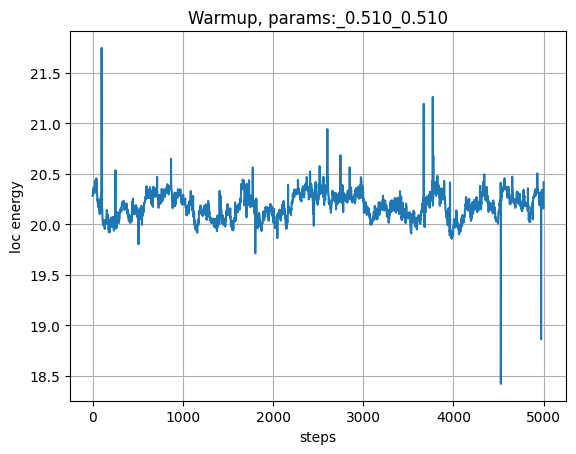

-----------------
VMC run
-----------------
Parameters: [0.51 0.51]
Acceptance rate: 0.51589
Time:  109.98536396026611
Energy: 20.188651268973256 +/- 0.003435305001110666


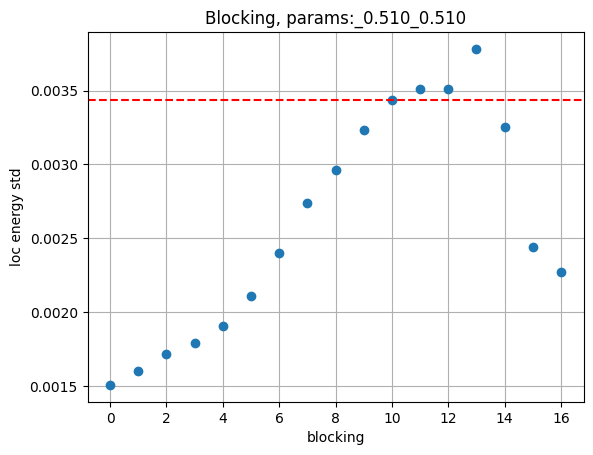

In [37]:
# warmup
vmc.calibrate()
vmc.warmup()
vmc.run()

## Compare with analytical results
In this section we compare the results of the grid search with the analytical results, in particular we show that the mean energy is the exact ground state energy of the system.

In [38]:
print('MC mean energy:', vmc.get_energy(), '+-', vmc.get_energy_std())  
print('Analytical energy:', 0.5*N*D, '+-', 0.0)

MC mean energy: 20.188651268973256 +- 0.003435305001110666
Analytical energy: 20.0 +- 0.0


In [31]:
10.047  10

10.0429

In [39]:
20.188/20

1.0093999999999999